In [1]:
from src.data import SegmentationData, SequentialSegmentationData
from nuscenes.nuscenes import NuScenes
from src.models import compile_model
from src.data import compile_data
from src.utils import convert_figure_numpy

from src.tools import plot_nusc_map, get_nusc_maps, add_ego
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import numpy as np

%matplotlib inline

In [2]:
version = 'mini'
dataroot = '/mnt/remote/data/users/anthony/datasets/nuscenes/mini'
nusc = NuScenes(version='v1.0-{}'.format(version),
                dataroot=dataroot,
                verbose=False)

In [3]:
H=900
W=1600
resize_lim=(0.193, 0.225)
final_dim=(128, 352)
bot_pct_lim=(0.0, 0.22)
rot_lim=(-5.4, 5.4)
rand_flip=False
xbound=[-50.0, 50.0, 0.5]
ybound=[-50.0, 50.0, 0.5]
zbound=[-10.0, 10.0, 20.0]
dbound=[4.0, 45.0, 1.0]
bsz=4
nworkers=6
grid_conf = {
    'xbound': xbound,
    'ybound': ybound,
    'zbound': zbound,
    'dbound': dbound,
}
cams = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
        'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
data_aug_conf = {
                'resize_lim': resize_lim,
                'final_dim': final_dim,
                'rot_lim': rot_lim,
                'H': H, 'W': W,
                'rand_flip': rand_flip,
                'bot_pct_lim': bot_pct_lim,
                'cams': cams,
                'Ncams': 5,
            }

In [4]:
val_dataset = SegmentationData(nusc, is_train=False, data_aug_conf=data_aug_conf, grid_conf=grid_conf,
                               dataroot=dataroot)
dummy_model_config = {
    'receptive_field': 10,
    'n_future': 5
}
seq_val_set = SequentialSegmentationData(nusc, is_train=False, data_aug_conf=data_aug_conf, grid_conf=grid_conf,
                               dataroot=dataroot, sequence_length=10)

NuscData: 81 samples. Split: val.
                   Augmentation Conf: {'resize_lim': (0.193, 0.225), 'final_dim': (128, 352), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': False, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'], 'Ncams': 5}
NuscData: 81 samples. Split: val.
                   Augmentation Conf: {'resize_lim': (0.193, 0.225), 'final_dim': (128, 352), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': False, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'], 'Ncams': 5}


In [5]:
model = compile_model(grid_conf, data_aug_conf, outC=1, name='basic')
model = model.to('cuda')

Loaded pretrained weights for efficientnet-b0


In [6]:
model_weights_path = './model_weights/model525000.pt'
model_weights = torch.load(model_weights_path, map_location='cuda')
# model_weights = torch.load(model_weights_path, map_location='cpu')
model.load_state_dict(model_weights)
model.eval()

LiftSplatShoot(
  (camencode): CamEncode(
    (trunk): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(

In [55]:
def convert_instance_mask_to_center_and_regression_label(instance_mask, num_instances, ignore_index=255):
    t, h, w = instance_mask.shape
    instance_ids = range(num_instances)
    center_label = torch.zeros(t, w, h, 1)
    future_displacement_label = torch.zeros(t, w, h, 2)
    regression_label = torch.zeros(t, w, h, 2)

    for instance_id in instance_ids:
        instance_points = torch.nonzero(instance_mask == instance_id)
        print(f' num instance points {len(instance_points)}')
        prev_center = None
        prev_instance_points_index = None
        for time in range(t):
            instance_points_at_time_index = instance_points[instance_points[:, 0] == time]
            instance_points_at_time_sliced = instance_points_at_time_index[:, 1:].float()
            
            if instance_points_at_time_index.shape[0]:
                max_points = torch.max(instance_points_at_time_sliced, dim=0, keepdims=True)[0]
                min_points = torch.min(instance_points_at_time_sliced, dim=0, keepdims=True)[0]
                instance_extent =  max_points - min_points
                instance_center =  torch.mean(instance_points_at_time_sliced, dim=0, keepdims=True)
                
                instance_points_to_center = instance_points_at_time_sliced - instance_center
                center_heatmap = 1 - torch.mean((2 * torch.abs(instance_points_to_center) / instance_extent), dim=1, keepdims=True)
                regression_label[
                    instance_points_at_time_index[:, 0], 
                    instance_points_at_time_index[:, 1], 
                    instance_points_at_time_index[:, 2]
                ] = instance_points_to_center
                center_label[
                    instance_points_at_time_index[:, 0], 
                    instance_points_at_time_index[:, 1], 
                    instance_points_at_time_index[:, 2]
                ] = center_heatmap
                
                if prev_center is not None:
                    future_displacement_label[
                        prev_instance_points_index[:, 0], 
                        prev_instance_points_index[:, 1], 
                        prev_instance_points_index[:, 2]
                    ] = instance_center - prev_center
                prev_center = instance_center
                prev_instance_points_index = instance_points_at_time_index
            else:
                prev_center = None
                prev_instance_points_index = None 
        
    return center_label, regression_label, future_displacement_label

writing data to cache for index - 30
writing data to cache for index - 31
writing data to cache for index - 32
writing data to cache for index - 33
writing data to cache for index - 34
writing data to cache for index - 35
writing data to cache for index - 36
writing data to cache for index - 37
writing data to cache for index - 38
writing data to cache for index - 39
 num instance points 476
 num instance points 439
 num instance points 436
 num instance points 553
 num instance points 50
 num instance points 467
 num instance points 444
 num instance points 213
 num instance points 486
 num instance points 431
 num instance points 425
 num instance points 363
 num instance points 26
 num instance points 502
 num instance points 479
 num instance points 486
 num instance points 206
 num instance points 545
 num instance points 431
 num instance points 420
 num instance points 408
 num instance points 36
 num instance points 319
 num instance points 69
 num instance points 446
 num inst

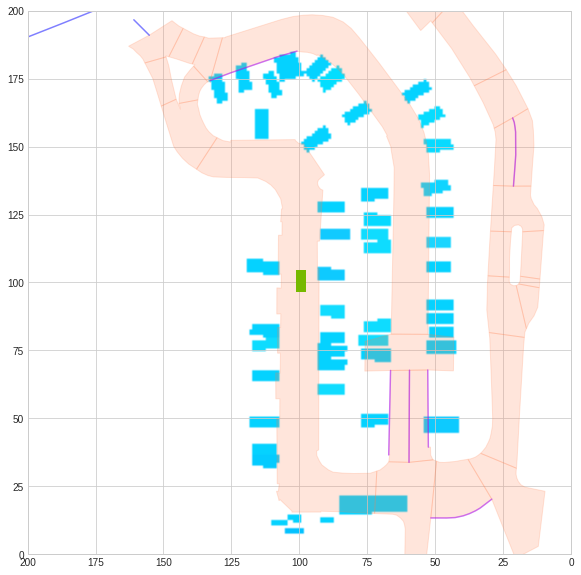

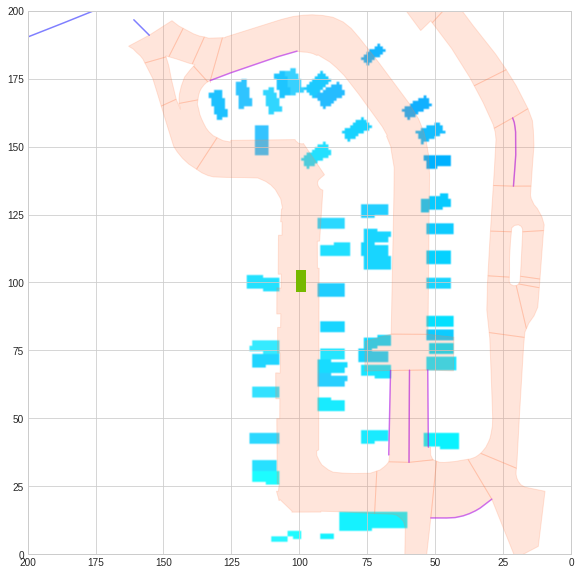

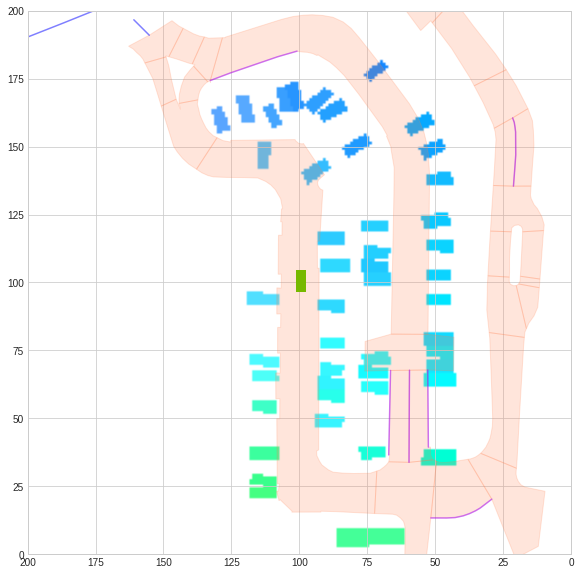

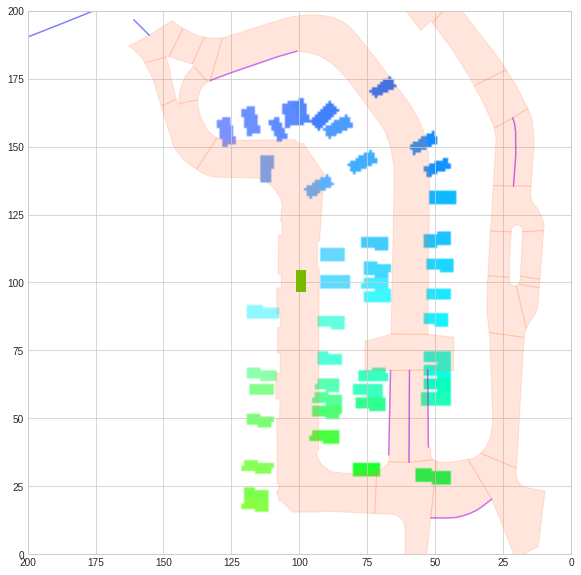

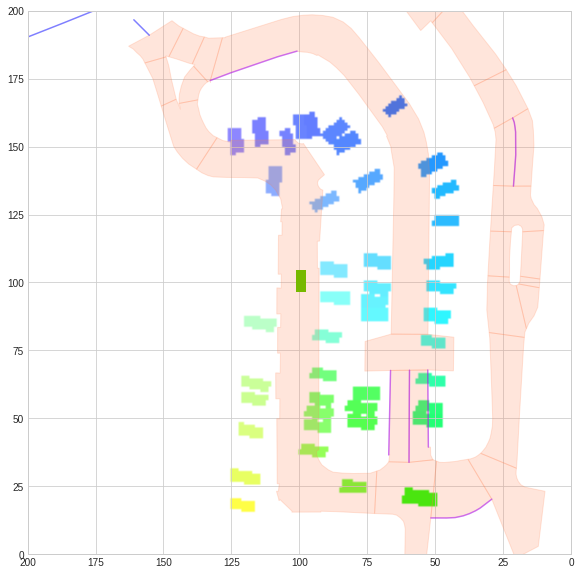

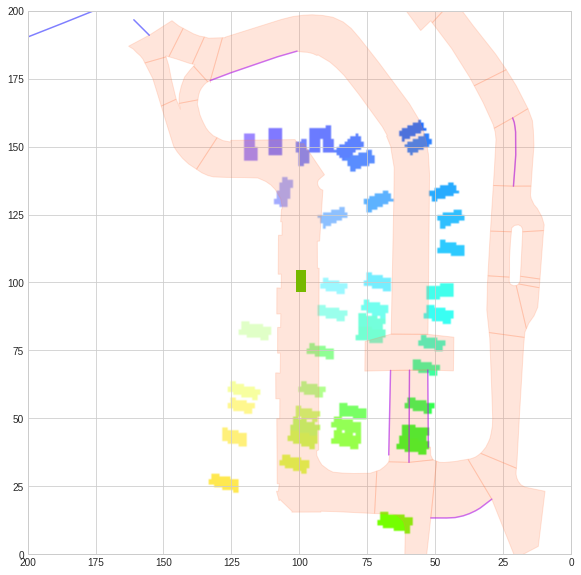

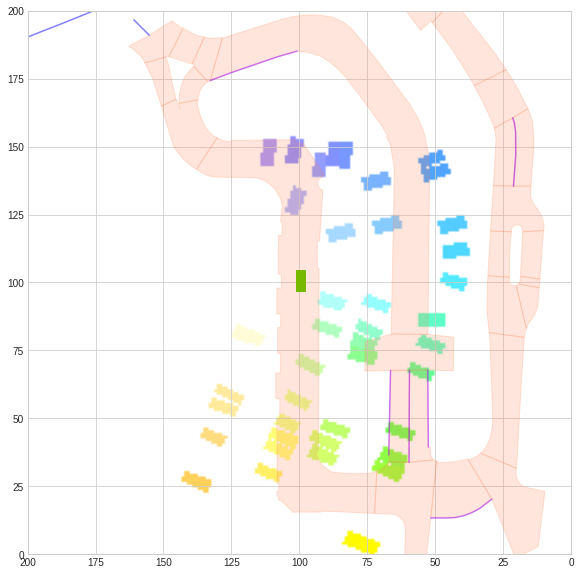

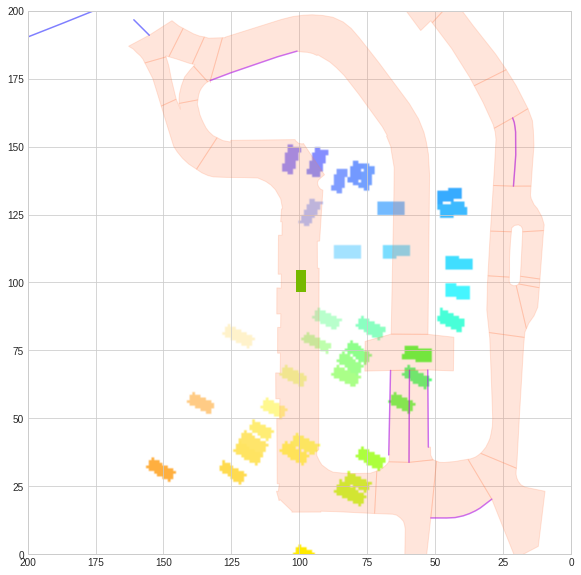

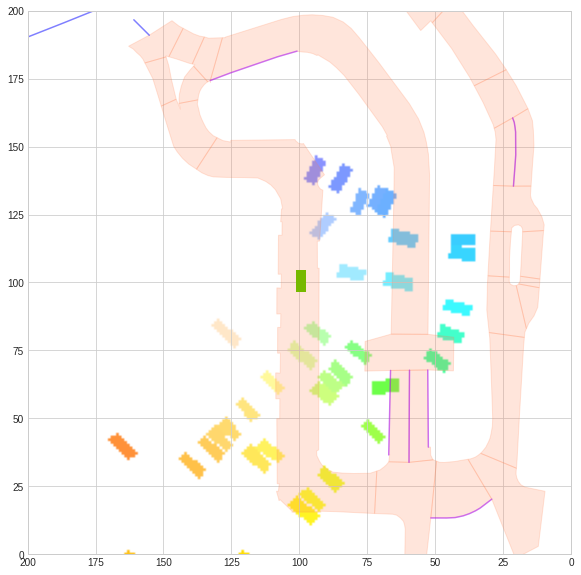

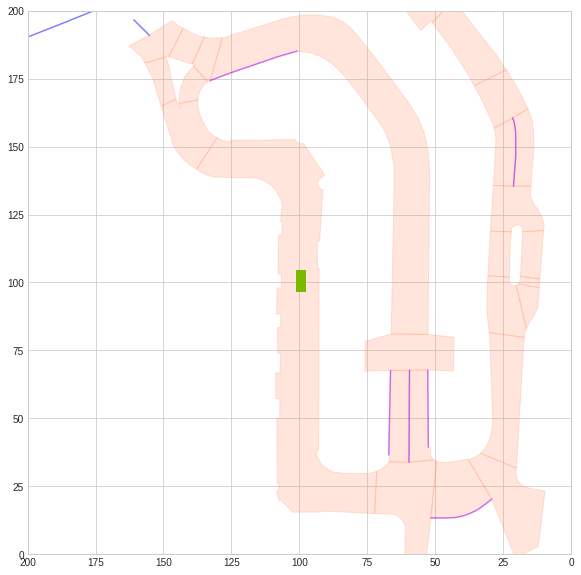

In [56]:
from src.utils import plot_instance_map, _generate_instance_colours, flow_to_image
dx, bx = val_dataset.dx[:2], val_dataset.bx[:2]

scene2map = {}
for rec in val_dataset.nusc.scene:
    log = val_dataset.nusc.get('log', rec['log_token'])
    scene2map[rec['name']] = log['location']
nusc_maps = get_nusc_maps(dataroot)

video_np = []
for t in [30]:
    imgs, rots, trans, intrins, post_rots, post_trans, binimg, future_egomotion, instance_image, instance_map = seq_val_set[t]
    center_label, regression_label, future_label = convert_instance_mask_to_center_and_regression_label(instance_image, len(instance_map))
    instance_colours = _generate_instance_colours(instance_map)
    for time in range(len(instance_image)):
        plt.figure(figsize=(10, 10))
#         plt.imshow(center_label[time].numpy(), cmap='jet')
#         plt.imshow(binimg[time].numpy())
        plt.imshow(flow_to_image(future_label[time].numpy()))
#         plt.imshow(flow_to_image(regression_label[time].numpy()))
#         plt.imshow(plot_instance_map(instance_image[time], instance_map, instance_colours=instance_colours))
        # plot static map (improves visualization)
        rec = val_dataset.ixes[t]
        plot_nusc_map(rec, nusc_maps, val_dataset.nusc, scene2map, dx, bx)
        plt.xlim((200, 0))
        plt.ylim((0, 200))
        add_ego(bx, dx)
        plt.draw()
    
        video_np.append(convert_figure_numpy(plt.gcf()))
    

In [24]:
index = 15
imgs, rots, trans, intrins, post_rots, post_trans, binimg, future_egomotion = val_dataset[index]
# imgs, rots, trans, intrins, post_rots, post_trans, binimg, future_egomotion = imgs[None, :].cuda(), rots[None, :].cuda(), \
#     trans[None, :].cuda(), intrins[None, :].cuda(), post_rots[None, :].cuda(), post_trans[None, :].cuda(), binimg[None, :].cuda(), \
#     future_egomotion[None, :].cuda()

with torch.no_grad():
    preds = model(imgs, rots, trans, intrins, post_rots, post_trans, future_egomotion)

In [16]:
imgs = imgs[0].cpu()
preds = preds['bev'][0].sigmoid()

In [17]:
imgs.shape

torch.Size([6, 3, 128, 352])

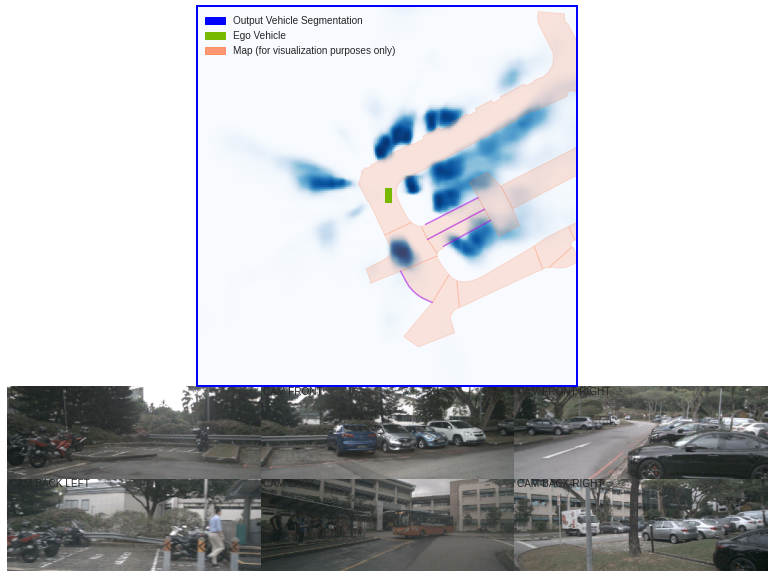

In [13]:
import matplotlib as mpl
import imageio
from PIL import Image
from src.tools import denormalize_img


# Vis with cameras
val = 0.01
fH, fW = final_dim
fig = plt.figure(figsize=(3*fW*val, (1.5*fW + 2*fH)*val))
gs = mpl.gridspec.GridSpec(3, 3, height_ratios=(1.5*fW, fH, fH))
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)


plt.clf()
for imgi, img in enumerate(imgs):
    ax = plt.subplot(gs[1 + imgi // 3, imgi % 3])
    showimg = denormalize_img(img)
    # flip the bottom images
    if imgi > 2:
        showimg = showimg.transpose(Image.FLIP_LEFT_RIGHT)
    plt.imshow(showimg)
    plt.axis('off')
    plt.annotate(cams[imgi].replace('_', ' '), (0.01, 0.92), xycoords='axes fraction')

ax = plt.subplot(gs[0, :])
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.setp(ax.spines.values(), color='b', linewidth=2)
plt.legend(handles=[
    mpatches.Patch(color=(0.0, 0.0, 1.0, 1.0), label='Output Vehicle Segmentation'),
    mpatches.Patch(color='#76b900', label='Ego Vehicle'),
    mpatches.Patch(color=(1.00, 0.50, 0.31, 0.8), label='Map (for visualization purposes only)')
], loc=(0.01, 0.86))
plt.imshow(preds.detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='Blues')

# plot static map (improves visualization)
rec = val_dataset.ixes[index]
plot_nusc_map(rec, nusc_maps, val_dataset.nusc, scene2map, dx, bx)
plt.xlim((200, 0))
plt.ylim((0, 200))
add_ego(bx, dx)
plt.draw()

video_np.append(convert_figure_numpy(fig))
